# Inference Kernel Demo

Kernel to test and run predictions on video dataset.

This Kernel is based on this [Kaggle Kernel](https://www.kaggle.com/humananalog/inference-demo)

We use MTCNN + a trained classifier to run predictions and tests.

In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Get the test videos

In [2]:
test_dir = "./data/test_videos"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

## Create helpers

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.4.0
CUDA version: 10.1
cuDNN version: 7603


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [ ]:
# from blazeface import BlazeFace
# face_detector = BlazeFace().to(gpu)
# face_detector.load_weights("./blazeface.pth")
# face_detector.load_anchors("./anchors.npy")
# _ = face_detector.train(False)

In [5]:
!pip install facenet_pytorch -q

In [6]:
from facenet_pytorch import MTCNN

In [7]:
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')
face_detector = mtcnn

In [8]:
class VideoReader():
    def __init__(self, frames_per_video=24):
        self.frames_per_video = frames_per_video
        
    def read_frames(self, video_path):
        frames = []
        capture = cv2.VideoCapture(video_path)

        success = 1
        count = 0

        while success: 

            success, frame = capture.read() 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame = cv2.resize(frame, (128, 128))

            frames.append(frame)

            count += 1
            
            if count >= self.frames_per_video:
                return frames            
        capture.release()
        return frames

In [9]:
# from helpers.read_video_1 import VideoReader
# from helpers.face_extract_1 import FaceExtractor

frames_per_video = 10

video_reader = VideoReader(frames_per_video=frames_per_video)
video_read_fn = lambda x: video_reader.read_frames(x)

In [10]:
## quick test
video_path = os.path.join('./data/test_videos', test_videos[1])

In [11]:
len(video_read_fn(video_path))

10

In [12]:
class FaceExtractor():
    def __init__(self, video_read_fn, face_detector):
        self.video_read_fn = video_read_fn
        self.face_detector = face_detector
        
    def keep_only_best_face(self, faces):
        faces = torch.max(torch.stack(faces, dim=0), axis=1).values
        for face in faces:
            face = face[:4]
        return faces
        
    def process_video(self, video_path):
        frames = self.video_read_fn(video_path)
        faces = []
        for frame in frames:
            faces.append(self.face_detector(frame))
            
        return faces, frames

In [13]:
face_extractor = FaceExtractor(video_read_fn, face_detector)

In [14]:
input_size = 224

In [15]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

## Creating an Ensemble

In [14]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Sequential(nn.Dropout(0.6),nn.Linear(2048, 1))
def add_fc_layer(model):
    model.fc = nn.Linear(2048, 1)
    return model

In [15]:
# checkpoint = models.resnet.resnext50_32x4d(pretrained=True).state_dict()

model = MyResNeXt().to(gpu)
model.load_state_dict(torch.load('./image-classifier-blur-checkpoint.pth'))

_ = model.eval()

# del checkpoint

In [ ]:
model2 = models.wide_resnet101_2(pretrained=True)
model2 = add_fc_layer(model2)
model2 = model2.to(gpu)

model2.load_state_dict(torch.load(trained_path))
_ = model2.eval()

In [75]:
## load efficientnet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7') 

Loaded pretrained weights for efficientnet-b7


In [76]:
## Transfer learn
num_features = model._fc.in_features

model._fc = nn.Linear(num_features, 1) ## Binary classifier

In [77]:
model = nn.DataParallel(model).to(gpu)

In [78]:
model.load_state_dict(torch.load('a-train-efficientnet-b7-deep-image-classifier-checkpoint.pth', map_location=gpu))

<All keys matched successfully>

In [79]:
_ = model.eval()
_ = model.train(False)

## Test Runs

In [80]:
def plot_detections(faces):
    fig, axes = plt.subplots(1, len(faces))
    for face, ax in zip(faces, axes):
        ax.imshow(face.permute(1, 2, 0).int().numpy())
        ax.axis('off')
    fig.show()

In [81]:
video_path = os.path.join('./data/test_videos', test_videos[2])

In [82]:
def read_frame(video_path):
    capture = cv2.VideoCapture(video_path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #frame = cv2.resize(frame, (128, 128))
    capture.release()
    return frame

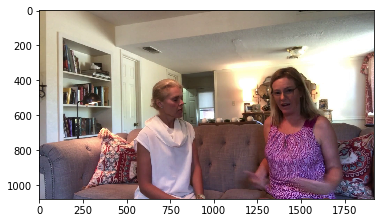

In [83]:
frame = read_frame(video_path)
plt.imshow(frame)

In [84]:
detections = face_detector(frame)

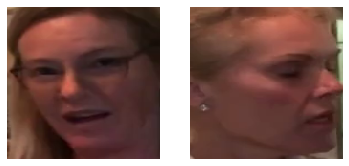

In [85]:
plot_detections(detections)

In [86]:
detections, frames = face_extractor.process_video(video_path)

In [87]:
type(detections)

list

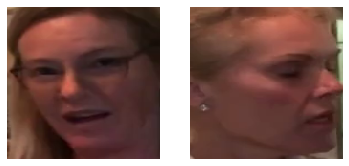

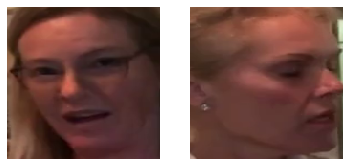

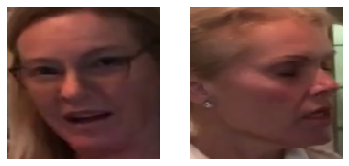

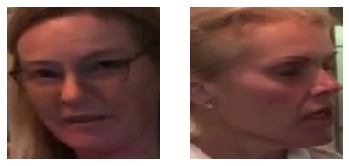

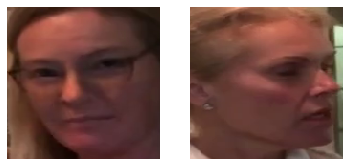

In [88]:
for index, frame in enumerate(frames[:5]):
    plot_detections(detections[index])

In [89]:
print(np.shape(detections[0]))

torch.Size([2, 3, 160, 160])


## Prediction loop

In [127]:
def predict_on_video(video_path, batch_size):
    #o=0
    try:
        # Find the faces for N frames in the video.
        faces, frames = face_extractor.process_video(video_path)
        # Only look at one face per frame.
        #faces = face_extractor.keep_only_best_face(faces)

        #looking at all faces in a frame
        #print("len",len(faces))
        #o=o+1
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            face_size=0
            for face in (faces):
                if(face is None):
                    face_size = face_size
                else:
                    for single_face in face:
                        face_size += 1

            x = np.zeros((face_size, input_size, input_size, 3), dtype=np.uint8)
            #print('face_size',face_size)
            # If we found any faces, prepare them for the model.
            n = 0
            for face in (faces):
                # Resize to the model's required input size.
                # We keep the aspect ratio intact and add zero
                # padding if necessary.     
                #face = crop_face(frames[index], face)
                #face = np.array(face)
                #q = 0
                if face is None:
                    n = n
                else:
                    for single_face in face:
                        #print('q',q)
                        #q=q+1
                        single_face = single_face.permute(1, 2, 0).int().numpy()
                        single_face = np.array(single_face)
                        #print(np.shape(single_face))
                        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
                        # ax1.axis('off')
                        # ax1.imshow(single_face, cmap=plt.cm.gray)
                        # ax1.set_title('Modified image')
                        # ax2.axis('off')
                        # ax2.imshow(single_face, cmap=plt.cm.gray)
                        # ax2.set_title('original face')
                        # plt.show()
                        #resized_face = isotropically_resize_image(single_face, input_size)
                        #print("here")
                        #resized_face = make_square_image(resized_face)
                        resized_face = cv2.resize(single_face.astype('float32'), (input_size, input_size),interpolation=cv2.INTER_AREA)
                        #print("where")
                        
                        x[n] = resized_face
                        #Put augumentation code here
                        x[n] = cv2.GaussianBlur(x[n],(5,5),0,3)
                        n += 1
                    
                
               
                # Test time augmentation: horizontal flips.
                # TODO: not sure yet if this helps or not
                #x[n] = cv2.flip(resized_face, 1)
                #n += 1
            #print('n',n)
            if n > 0:
                x = torch.tensor(x, device=gpu).float()
                #print(x.size())
                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)
                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred1 = model(x)
                    y_pred1 = torch.sigmoid(y_pred1.squeeze())
                    #y_pred2 = model2(x)
                    #y_pred2 = torch.sigmoid(y_pred2.squeeze())
                    #y_pred = (y_pred1+y_pred2)/2
                    #print(y_pred)
                    y_pred, indices = torch.sort(y_pred1,descending = True)
                    if n<5 and n>1:
                        return y_pred[:n].mean().item()
                    if n==1:
                        return y_pred
                    else:
                        return y_pred[:5].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [91]:
predict_on_video(video_path, frames_per_video)

0.9992508888244629

In [92]:
y_pred = predict_on_video(os.path.join(train_dir, 'axwgcsyphv.mp4'), batch_size=frames_per_video)

In [93]:
y_pred

tensor(0.9224, device='cuda:0')

In [94]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers, data_dir=test_dir):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(data_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Evaluation

In [95]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report

In [96]:
train_dir = "./data/train_sample_videos" ## One sample of training data

metadata = pd.read_json('./data/train_sample_videos/metadata.json').T
metadata

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4
...,...,...,...
etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
eudeqjhdfd.mp4,REAL,train,None


In [97]:
train_videos = list(list(metadata.index))
len(train_videos)

400

In [98]:
y_truth = list((metadata['label'] == 'FAKE').astype(np.int))
# sanity check
sum(y_truth)

323

In [99]:
predictions = predict_on_video_set(train_videos, num_workers=5, data_dir=train_dir)

In [100]:
y_truth, predictions = np.array(y_truth), np.array(predictions)

In [101]:
# Compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_truth, predictions)
roc_auc = auc(fpr, tpr)

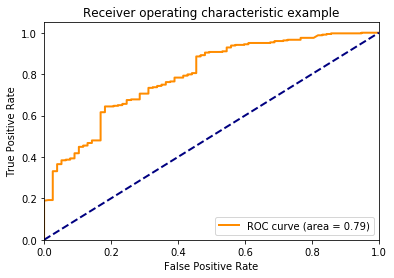

In [102]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [103]:
threshold = 0.5
pred_labels = np.where(predictions < threshold, 0, 1)

In [104]:
accuracy_score(y_truth, pred_labels)

0.8325

In [105]:
print(classification_report(y_truth, pred_labels, target_names=["FAKE", "REAL"]))

              precision    recall  f1-score   support

        FAKE       0.78      0.18      0.29        77
        REAL       0.84      0.99      0.90       323

    accuracy                           0.83       400
   macro avg       0.81      0.58      0.60       400
weighted avg       0.82      0.83      0.79       400



In [115]:
type(predictions), type(y_truth)

(numpy.ndarray, numpy.ndarray)

In [122]:
# Loss:
F.binary_cross_entropy_with_logits(
    torch.from_numpy(predictions.astype(np.float64)), 
    torch.from_numpy(y_truth.astype(np.float64))
)

tensor(0.4857, dtype=torch.float64)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [ ]:
speed_test = False  # you have to enable this manually

In [ ]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

## Make the submission

In [ ]:
predictions = predict_on_video_set(test_videos[:2], num_workers=4)

In [ ]:
predictions

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join('./data/test_videos', video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

In [ ]:
play_video(test_videos[0])

In [ ]:
predictions[0]